<a href="https://colab.research.google.com/github/JMFerret/colab/blob/main/2_stocks_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating correlated price stocks in a multi-asset basket
This notebook demonstrates how to simulate price paths in a basket containing >2 correlated assets. To achieve this, it applies [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)  on the correlation matrix and generates an array of correlated random numbers. The notebook only serves a narrow demonstration purpose and as such lacks certain user flexiblities.

## Import libraries

In [93]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
import pandas as pd

## Set coefficient matrix
Observe that the number of stocks and the coefficient matrix $\Sigma$ are treated as constants. When adjusting manually, carefully check that the matrix dimensions align with the number of stocks and that the correlation matrix is semi-definite positive (requirement for Cholesky decomposition).

For this example, volatilies and correlation coefficients for the [Big Tech companies](https://en.wikipedia.org/wiki/Big_Tech)  over 2020 were calculated.

In [94]:
# Manually input number of stocks
NUMBER_OF_STOCKS = 2

STOCK_TICKERS = ["AAPL", "AMZN"]

vol = 0.8

VOLATILITY_ARRAY =[vol, vol]

correl = 0.1

COEF_MATRIX = np.array([
    [1.0, correl],
    [correl, 1.0],
])

stock_data = {}
stock_data['AAPL'] = {'Vol': vol, 'Weight': 0.5}
stock_data['AMZN'] = {'Vol': vol, 'Weight': 0.5}


## Perform Cholesky decomposition
This cell performs the Cholesky decomposition on the coefficient matrix $\Sigma$, returning a matrix $R$ that satisfies $\Sigma=R R^*$ and $R^*$ being the conjugate transpose of $R$. Note that the other computations are only for validation purposes.

In [95]:
# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(COEF_MATRIX)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

# Reconstruct coefficient matrix from factorization (only for validation)
print(np.dot(R, RT))

[[1.  0.1]
 [0.1 1. ]]


## Initialize simulation properties
For simplicitly, all stocks have the same initial price $S_{n,0}$ and the same volatility $v_n$.

In [96]:
T = 252                                                  # Number of simulated days
stock_price_array = np.full((NUMBER_OF_STOCKS,T), 100.0) # Stock price, first value is simulation input 
volatility_array = VOLATILITY_ARRAY                      # Volatility (annual, 0.01=1%)
r = 0.001                                                # Risk-free rate (annual, 0.01=1%)
dt = 1.0 / T                                             # Time increment (annualized)

## Run simulation
For each time step, the cell generates a number of standard normal numbers (randomly drawn) and multiplies this with the $R$ matrix obtained from the Cholesky decomposition, yielding an epsilon array with correlated values. Mathematically, this procedure is denoted by $[\epsilon_n]_{\forall n \in \mathcal{N}} =R[x_n]_{\forall n \in \mathcal{N}}$, with $\mathcal{N}$ being the set of assets. The epsilons $\epsilon_n$ are used as inputs for the boilerplate return formula as derived from the Black-Scholes model: $S_t=S_{t-1} * e^{\left(r_f - \frac{\sigma ^2}{2}\right)}  dt + \sigma  \sqrt{dt}  \epsilon_n$

In [97]:
for t in range(1, T):
    # Generate array of random standard normal draws
    random_array = np.random.standard_normal(NUMBER_OF_STOCKS)
    
    # Multiply R (from factorization) with random_array to obtain correlated epsilons
    epsilon_array = np.inner(random_array,R)

    # Sample price path per stock
    for n in range(NUMBER_OF_STOCKS):
        dt = 1 / T 
        S = stock_price_array[n,t-1]
        v = volatility_array[n]
        epsilon = epsilon_array[n]
        
        # Generate new stock price
        stock_price_array[n,t] = S * exp((r - 0.5 * v**2) * dt + v * sqrt(dt) * epsilon)

## Plot simulated paths
With the default settings, the price paths should be highly correlated.

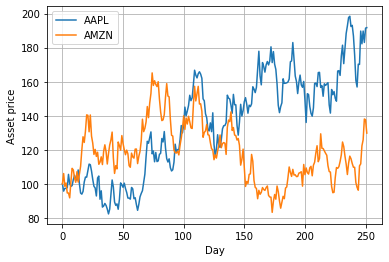

In [98]:
# Plot simulated price paths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))

plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [99]:
weights = {} 
for stock in STOCK_TICKERS:
  weights[stock] = 1 / NUMBER_OF_STOCKS

index = []
for t in range(T):
  index.append(0)
  for i, stock in enumerate(STOCK_TICKERS):
    index[t] += weights[stock] * stock_price_array[i][t]


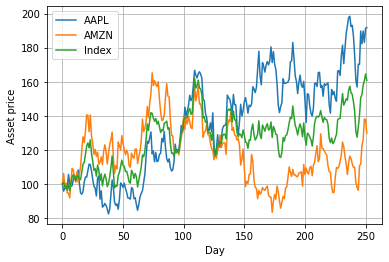

In [100]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))
    
ax.plot(array_day_plot, index, label = 'Index')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [111]:
df = pd.DataFrame(stock_price_array)
df = df.transpose()
df = df.rename(columns={0: "AAPL", 1: "AMZN"})
df["Index"] = index
cols = ["AAPL", "AMZN", "Index"]
for col in cols:
  df[col + '_returns'] = df[col].pct_change(1)

df['Prtf_val_s'] = 0.0
df['Prtf_val_e'] = 0.0

df.at[0, 'Prtf_val_s'] +=  np.nan
df.at[0, 'Prtf_val_e'] = 100

for stock in stock_data.keys():
  df[stock + '_wt_s'] = 0.0
  df[stock + '_wt_e'] = 0.0
  df[stock + '_val_s'] = 0.0
  df[stock + '_val_e'] = 0.0
  df[stock + '_nos_s'] = 0.0
  df[stock + '_nos_e'] = 0.0
  df.at[0, stock + '_wt_s'] = np.nan
  df.at[0, stock + '_val_s'] = np.nan
  df.at[0, stock + '_nos_s'] = np.nan
  df.at[0, stock + '_wt_e'] = stock_data[stock]['Weight']
  df.at[0, stock + '_val_e'] = df['Prtf_val_e'].iloc[0] * df[stock + '_wt_e'].iloc[0]
  df.at[0, stock + '_nos_e'] = df[stock + '_val_e'].iloc[0] / df[stock].iloc[0]
  

for t in range(1, T):

  df.at[t, 'Prtf_val_s'] = df['Prtf_val_e'].iloc[t-1]

  rebalance = False
  for stock in stock_data.keys():
    threshold = stock_data[stock]['Vol'] / sqrt(252)
    threshold = 1000
    if abs(df[stock + '_returns'].iloc[t-1]) > threshold:
      rebalance = True  # rebalance if one of the stocks moved more than its daily vol

  for stock in stock_data.keys():
    if rebalance:  # if rebalance
      df.at[t, stock + '_wt_s'] = stock_data[stock]['Weight']  # start weight = initial weight
      df.at[t, stock + '_val_s'] = df['Prtf_val_s'].iloc[t] * df[stock + '_wt_s'].iloc[t]  # start stock value = start prtf value * start weight
      df.at[t, stock + '_nos_s'] = df[stock + '_val_s'].iloc[t] / df[stock].iloc[t-1]  # start number of shares = start stock value / prev close
    
    else:  # no rebalance
      df.at[t, stock + '_wt_s'] = df[stock + '_wt_e'].iloc[t-1] # start weight = prev end weight
      df.at[t, stock + '_val_s'] = df[stock + '_val_e'].iloc[t-1] # start stock val = prev end stock val
      df.at[t, stock + '_nos_s'] = df[stock + '_nos_e'].iloc[t-1] # start nos = prev end nos

    df.at[t, stock + '_nos_e'] = df[stock + '_nos_s'].iloc[t]  # end nos = start nos
    df.at[t, stock + '_val_e'] = df[stock + '_nos_e'].iloc[t] * df[stock].iloc[t] # end stock val = end nos * close

    df.at[t, 'Prtf_val_e'] += df[stock + '_val_e'].iloc[t]  # end prtf val = sum end stock val

  for stock in stock_data.keys():
    df.at[t, stock + '_wt_e'] = df[stock + '_val_e'].iloc[t] / df['Prtf_val_e'].iloc[t]  # end weight = end stock val / end prtf val



,AAPL,AMZN,Index,AAPL_returns,AMZN_returns,Index_returns,Prtf_val_s,Prtf_val_e,AAPL_wt_s,AAPL_wt_e,AAPL_val_s,AAPL_val_e,AAPL_nos_s,AAPL_nos_e,AMZN_wt_s,AMZN_wt_e,AMZN_val_s,AMZN_val_e,AMZN_nos_s,AMZN_nos_e
0,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,100.000000,NaN,0.500000,NaN,50.000000,NaN,0.5,NaN,0.500000,NaN,50.000000,NaN,0.5
1,95.727787,106.050530,100.889159,-0.042722,0.060505,0.008892,100.000000,100.889159,0.500000,0.474421,50.000000,47.863894,0.5,0.5,0.500000,0.525579,50.000000,53.025265,0.5,0.5
2,97.347143,98.551963,97.949553,0.016916,-0.070707,-0.029137,100.889159,97.949553,0.474421,0.496925,47.863894,48.673571,0.5,0.5,0.525579,0.503075,53.025265,49.275982,0.5,0.5
3,97.373951,100.503270,98.938611,0.000275,0.019800,0.010098,97.949553,98.938611,0.496925,0.492093,48.673571,48.686975,0.5,0.5,0.503075,0.507907,49.275982,50.251635,0.5,0.5
4,97.737842,94.647606,96.192724,0.003737,-0.058263,-0.027753,98.938611,96.192724,0.492093,0.508031,48.686975,48.868921,0.5,0.5,0.507907,0.491969,50.251635,47.323803,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,182.233608,122.306320,152.269964,-0.039426,0.094776,0.010313,150.715666,152.269964,0.629375,0.598390,94.856602,91.116804,0.5,0.5,0.370625,0.401610,55.859065,61.153160,0.5,0.5
248,189.733068,125.864903,157.798986,0.041153,0.029096,0.036311,152.269964,157.798986,0.598390,0.601186,91.116804,94.866534,0.5,0.5,0.401610,0.398814,61.153160,62.932451,0.5,0.5
249,183.035594,138.097746,160.566670,-0.035299,0.097190,0.017539,157.798986,160.566670,0.601186,0.569968,94.866534,91.517797,0.5,0.5,0.398814,0.430032,62.932451,69.048873,0.5,0.5
250,191.434141,137.599466,164.516804,0.045885,-0.003608,0.024601,160.566670,164.516804,0.569968,0.581807,91.517797,95.717071,0.5,0.5,0.430032,0.418193,69.048873,68.799733,0.5,0.5


In [107]:
# Check realised vol
for stock in stock_data.keys():
  print(f"{stock} Realised Vol: {100 * round(df[stock + '_returns'].dropna().std() * np.sqrt(T), 2)}")
  print(f"{stock} Input Vol: {100 * round(stock_data[stock]['Vol'], 2)}")
  print(f"{stock} Input Daily Vol: {100 * round(stock_data[stock]['Vol'] / sqrt(252), 2)}")

AAPL Realised Vol: 76.0
AAPL Input Vol: 80.0
AAPL Input Daily Vol: 5.0
AMZN Realised Vol: 81.0
AMZN Input Vol: 80.0
AMZN Input Daily Vol: 5.0


In [103]:
for stock in stock_data.keys():
  print(stock)

AAPL
AMZN


In [104]:
stock_data['AAPL']['Vol'] / sqrt(252)

0.05039526306789696

In [105]:
data = {'toto':[1,2], 'tata':[3,4]}
dft = pd.DataFrame(data)
for i in range(len(dft)):
  print(dft['tata'].iloc[i])

3
4
